In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as bs
import os
import sys
import requests
import re

In [2]:
#데이터 수집 : 국내시판 기준, 인기있는 자동차에 국한하여 크롤링 from 네이버 자동차
carIDDF =pd.DataFrame()
car_temp =pd.DataFrame()

car_temp = car_temp.append(
    {
        "carFrom" : "",
        "company" : "",
        "carNm" :"",
        "price(만원)":"",
        "fuelEfficiency":"",
        "fuel":"",
        "size":""},
    ignore_index =True)
temp_car_idx =car_temp.columns.get_loc("carFrom")
temp_com_idx =car_temp.columns.get_loc("company")
temp_carNm_idx =car_temp.columns.get_loc("carNm")
temp_price_idx =car_temp.columns.get_loc("price(만원)")
temp_fuelEfficiency_idx =car_temp.columns.get_loc("fuelEfficiency")
temp_fuel_idx =car_temp.columns.get_loc("fuel")
temp_size_idx =car_temp.columns.get_loc("size")

# -1) 국산차 데이터 수집
domesticCarList = ["16", "12", "13","15","61321"]
importYn = "N"

for d in domesticCarList :      
    url_part1 ="""https://auto.naver.com/company/main.nhn?mnfcoNo="""+d + "&modelType=OS&order=0&importYn=" +importYn +"&lnchYY=-1&saleType=0"
    res = requests.get(url_part1) 
    carData = bs(res.text, "html.parser")
    
    # page 수 구하는 과정
    page=0
    temp_page = carData.find_all("div", class_="paginate2")[0].find_all("a")
    if carData.find_all("div", class_="paginate2")!=1 :
        page+=1
    for i in range(0, len(temp_page)) :
        if temp_page[i].text ==str(i+2) :
            page+=1
        
    for z in range(1,page+1):
        url = url_part1+ "&page=" + str(z)
        res = requests.get(url) 
        carData = bs(res.text, "html.parser")

        
        tempNumCount=len(carData.find_all("div", class_="model_ct"))

        for i in range(0, tempNumCount) :
            if importYn=="N" :
                car_temp.iat[0, temp_car_idx] = "국산"
            else :
                car_temp.iat[0, temp_car_idx] = "수입"

            car_temp.iat[0, temp_com_idx] = carData.find_all("div", class_="model_ct")[0].find_all("img")[1].get("alt")
            car_temp.iat[0, temp_carNm_idx] = carData.find_all("span", class_="box")[i].text

            if len(carData.find_all("div", class_="model_ct")[i].find_all("span", class_="cont"))==1 :
                car_temp.iat[0, temp_price_idx] = carData.find_all("div", class_="model_ct")[i].find_all("span", class_="empty")[0].text
            else :
                car_temp.iat[0, temp_price_idx] = carData.find_all("div", class_="model_ct")[i].find_all("span", class_="cont")[0].text

                if carData.find_all("div", class_="model_ct")[i].find_all("span", class_="ko")[1].text=="루피" :
                    if len(car_temp.iat[0, temp_price_idx].split("~"))==1 :
                        car_temp.iat[0, temp_price_idx]=str(format(round((int((car_temp.iat[0, temp_price_idx]).replace(",", "")) *15.98)/10000),","))
                    else : 
                        carprice=carData.find_all("div", class_="model_ct")[i].find_all("span", class_="cont")[0].text
                        car_temp.iat[0, temp_price_idx]=str(format(round((int(carprice.split("~")[0].replace(",",""))*15.98)/10000),","))+ "~" +str(format(round((int(carprice.split("~")[1].replace(",", ""))*15.98)/10000),","))
                elif carData.find_all("div", class_="model_ct")[i].find_all("span", class_="ko")[1].text=="달러" :  
                    if len(car_temp.iat[0, temp_price_idx].split("~"))==1 :
                        car_temp.iat[0, temp_price_idx]=str(format(round((int((car_temp.iat[0, temp_price_idx]).replace(",", "")) *1195.70)/10000),","))
                    else : 
                        carprice=carData.find_all("div", class_="model_ct")[i].find_all("span", class_="cont")[0].text
                        car_temp.iat[0, temp_price_idx]=str(format(round((int(carprice.split("~")[0].replace(",",""))*1195.70)/10000),","))+ "~" +str(format(round((int(carprice.split("~")[1].replace(",", ""))*1195.70)/10000),","))
                elif carData.find_all("div", class_="model_ct")[i].find_all("span", class_="ko")[1].text=="파운드" :  
                    if len(car_temp.iat[0, temp_price_idx].split("~"))==1 :
                        car_temp.iat[0, temp_price_idx]=str(format(round((int((car_temp.iat[0, temp_price_idx]).replace(",", "")) *1502.12)/10000),","))
                    else : 
                        carprice=carData.find_all("div", class_="model_ct")[i].find_all("span", class_="cont")[0].text
                        car_temp.iat[0, temp_price_idx]=str(format(round((int(carprice.split("~")[0].replace(",",""))*1502.12)/10000),","))+ "~" +str(format(round((int(carprice.split("~")[1].replace(",", ""))*1502.12)/10000),","))
                else :
                    pass

            car_temp.iat[0, temp_fuelEfficiency_idx] =carData.find_all("div", class_="model_ct")[i].find_all("span", class_="en")[0].text
            car_temp.iat[0, temp_fuel_idx] = (carData.find_all("div", class_="model_ct")[i].find_all("span", class_="ell")[1].text).strip()
            if len(carData.find_all("div", class_="model_ct")[i].find_all("span", class_="cont"))==1 :
                car_temp.iat[0, temp_size_idx] =(carData.find_all("div", class_="model_ct")[i].find_all("span", class_="cont")[0]).text
            else : 
                car_temp.iat[0, temp_size_idx] = (carData.find_all("div", class_="model_ct")[i].find_all("span", class_="cont")[1]).text

            carIDDF=carIDDF.append(car_temp,ignore_index = True)

            for j in range(2, len(car_temp.columns)) :
                car_temp.iat[0,j] =""

In [3]:
# -1) 수입차 데이터 수집
importCarList = ["21", "48", "23", "18", "20", "25","39","24", "6435", "30", "35","19","40","3905","3976","41","22","31","33", "34"]
importYn = "Y"

for d in importCarList :      
    url_part1 ="""https://auto.naver.com/company/main.nhn?mnfcoNo="""+d + "&modelType=OS&order=0&importYn=" +importYn +"&lnchYY=-1&saleType=0"
    res = requests.get(url_part1) 
    carData = bs(res.text, "html.parser")

    page=0
    temp_page = carData.find_all("div", class_="paginate2")[0].find_all("a")
    if carData.find_all("div", class_="paginate2")!=1 :
        page+=1
    for i in range(0, len(temp_page)) :
        if temp_page[i].text ==str(i+2) :
            page+=1
        
    for z in range(1,page+1):
        url = url_part1+ "&page=" + str(z)
        res = requests.get(url) 
        carData = bs(res.text, "html.parser")

        tempNumCount=len(carData.find_all("div", class_="model_ct"))

        for i in range(0, tempNumCount) :
            if importYn=="N" :
                car_temp.iat[0, temp_car_idx] = "국산"
            else :
                car_temp.iat[0, temp_car_idx] = "수입"

            car_temp.iat[0, temp_com_idx] = carData.find_all("div", class_="model_ct")[0].find_all("img")[1].get("alt")
            car_temp.iat[0, temp_carNm_idx] = carData.find_all("span", class_="box")[i].text

            if len(carData.find_all("div", class_="model_ct")[i].find_all("span", class_="cont"))==1 :
                car_temp.iat[0, temp_price_idx] = carData.find_all("div", class_="model_ct")[i].find_all("span", class_="empty")[0].text
            else :
                car_temp.iat[0, temp_price_idx] = carData.find_all("div", class_="model_ct")[i].find_all("span", class_="cont")[0].text

                if carData.find_all("div", class_="model_ct")[i].find_all("span", class_="ko")[1].text=="루피" :
                    if len(car_temp.iat[0, temp_price_idx].split("~"))==1 :
                        car_temp.iat[0, temp_price_idx]=str(format(round((int((car_temp.iat[0, temp_price_idx]).replace(",", "")) *15.98)/10000),","))
                    else : 
                        carprice=carData.find_all("div", class_="model_ct")[i].find_all("span", class_="cont")[0].text
                        car_temp.iat[0, temp_price_idx]=str(format(round((int(carprice.split("~")[0].replace(",",""))*15.98)/10000),","))+ "~" +str(format(round((int(carprice.split("~")[1].replace(",", ""))*15.98)/10000),","))
                elif carData.find_all("div", class_="model_ct")[i].find_all("span", class_="ko")[1].text=="달러" :  
                    if len(car_temp.iat[0, temp_price_idx].split("~"))==1 :
                        car_temp.iat[0, temp_price_idx]=str(format(round((int((car_temp.iat[0, temp_price_idx]).replace(",", "")) *1195.70)/10000),","))
                    else : 
                        carprice=carData.find_all("div", class_="model_ct")[i].find_all("span", class_="cont")[0].text
                        car_temp.iat[0, temp_price_idx]=str(format(round((int(carprice.split("~")[0].replace(",",""))*1195.70)/10000),","))+ "~" +str(format(round((int(carprice.split("~")[1].replace(",", ""))*1195.70)/10000),","))
                elif carData.find_all("div", class_="model_ct")[i].find_all("span", class_="ko")[1].text=="파운드" :  
                    if len(car_temp.iat[0, temp_price_idx].split("~"))==1 :
                        car_temp.iat[0, temp_price_idx]=str(format(round((int((car_temp.iat[0, temp_price_idx]).replace(",", "")) *1502.12)/10000),","))
                    else : 
                        carprice=carData.find_all("div", class_="model_ct")[i].find_all("span", class_="cont")[0].text
                        car_temp.iat[0, temp_price_idx]=str(format(round((int(carprice.split("~")[0].replace(",",""))*1502.12)/10000),","))+ "~" +str(format(round((int(carprice.split("~")[1].replace(",", ""))*1502.12)/10000),","))
                else :
                    pass

            car_temp.iat[0, temp_fuelEfficiency_idx] =carData.find_all("div", class_="model_ct")[i].find_all("span", class_="en")[0].text
            car_temp.iat[0, temp_fuel_idx] = (carData.find_all("div", class_="model_ct")[i].find_all("span", class_="ell")[1].text).strip()
            if len(carData.find_all("div", class_="model_ct")[i].find_all("span", class_="cont"))==1 :
                car_temp.iat[0, temp_size_idx] =(carData.find_all("div", class_="model_ct")[i].find_all("span", class_="cont")[0]).text
            else : 
                car_temp.iat[0, temp_size_idx] = (carData.find_all("div", class_="model_ct")[i].find_all("span", class_="cont")[1]).text

            carIDDF=carIDDF.append(car_temp,ignore_index = True)

            for j in range(2, len(car_temp.columns)) :
                car_temp.iat[0,j] =""
carIDDF

,carFrom,carNm,company,fuel,fuelEfficiency,price(만원),size
0,국산,2020 아반떼,현대,"가솔린, LPG",10.5~15.4km/ℓ,"1,570~2,453",준중형
1,국산,2020 싼타페,현대,디젤,12.8~14.2km/ℓ,"3,122~4,212",중형
2,국산,2020 팰리세이드,현대,"디젤, 가솔린",8.9~12.4km/ℓ,"3,573~5,563",준대형
3,국산,2020 그랜저,현대,"가솔린, LPG",7.4~11.9km/ℓ,"3,172~4,349",준대형
4,국산,2020 투싼,현대,"디젤, 가솔린",10.4~16.3km/ℓ,"2,255~3,293",준중형
...,...,...,...,...,...,...,...
291,수입,2019 닛산 맥시마,닛산,가솔린,9.4km/ℓ,"4,520",준대형
292,수입,2019 닛산 리프,닛산,전기,5.1km/kWh,"4,190~4,830",준중형
293,수입,2019 인피니티 QX60,인피니티,가솔린,8.7~8.9km/ℓ,"5,847~6,277",준대형
294,수입,2019 인피니티 QX50,인피니티,가솔린,9.8~10.3km/ℓ,"5,127~6,277",중형


In [4]:
#전기차 삭제
carIDDF=carIDDF.drop(carIDDF[carIDDF["fuel"]=="전기"].index, axis=0)

In [5]:
#수소차 삭제 
carIDDF=carIDDF.drop(carIDDF[carIDDF["fuel"]=="수소"].index, axis=0)

In [6]:
#price => basicPrice
carIDDF["basicPrice(만원)"] = carIDDF["price(만원)"].apply(lambda x : int(x.split("~")[0].split('억')[0])*10000 +int(x.split("~")[0].split('억')[1].replace(',','')) if x.split("~")[0].find('억')!=-1
                          else("None" if x.split("~")[0]=="정보없음" else int(x.split("~")[0].replace(',', '')))) 

In [7]:
#price => optionPrice
carIDDF["optionPrice(만원)"] = carIDDF["price(만원)"].apply(lambda x : "None" if len(x.split("~"))==1 else(int(x.split("~")[1].split('억')[0])*10000 +int(x.split("~")[1].split('억')[1].replace(',','')) if x.split("~")[1].find('억')!=-1 else int(x.split("~")[1].replace(',', ''))))

In [8]:
#fuelEfficiency => fuelEfficiency.mean()
carIDDF["Avg_Fuel"]=carIDDF["fuelEfficiency"].apply(lambda x : (float(re.sub(r"k.*","",x).split("~")[0]) +float(re.sub(r"k.*","",x).split("~")[1]))/2 if len(re.sub(r"k.*","",x).split("~"))==2 else(float(re.sub(r"k.*","",x)) if re.sub(r"k.*","",x).split("~")[0]!="정보없음" else "None"))

In [9]:
#None값 정보삭제
carIDDF=carIDDF.drop(carIDDF["basicPrice(만원)"][carIDDF["basicPrice(만원)"]=="None"].index, axis=0)

In [10]:
#None값 정보삭제
carIDDF=carIDDF.drop(carIDDF["optionPrice(만원)"][carIDDF["optionPrice(만원)"]=="None"].index, axis=0)

In [11]:
#None값 정보삭제
carIDDF=carIDDF.drop(carIDDF["Avg_Fuel"][carIDDF["Avg_Fuel"]=="None"].index, axis=0)

In [12]:
#columns 순서 변경
col_list=["company", "carFrom","carNm", "size", "fuel", "fuelEfficiency","Avg_Fuel","basicPrice(만원)","optionPrice(만원)", "price(만원)"]
carIDDF=carIDDF[col_list]

In [13]:
#칼럼이름 변경
carIDDF.rename(columns=({'company':'Company',
                      'carFrom':'Car',
                      'carNm' : 'CarNm',
                      'size':'Size'
                    ,'fuel':'Fuel','fuelEfficiency':'Fuel_Efficiency(km/ℓ)'
                      ,'basicPrice(만원)':'BasicPrice(만원)','optionPrice(만원)':'OptionPrice(만원)'
                     ,'price(만원)':'Price(만원)'
                        ,'Avg_Fuel' :'Avg_Fuel(km/ℓ)'}),inplace=True)

In [14]:
#컬럼타입 변경 
carIDDF=carIDDF.astype({"BasicPrice(만원)":int })
carIDDF=carIDDF.astype({"OptionPrice(만원)":int })
carIDDF=carIDDF.astype({"Avg_Fuel(km/ℓ)":int })

In [15]:
#index 리셋
carIDDF=carIDDF.reset_index(drop=True)

In [16]:
#basicPrice(만원) 순으로 정렬
carIDDF = carIDDF.sort_values(by="BasicPrice(만원)")

In [17]:
carIDDF

,Company,Car,CarNm,Size,Fuel,Fuel_Efficiency(km/ℓ),Avg_Fuel(km/ℓ),BasicPrice(만원),OptionPrice(만원),Price(만원)
74,쉐보레,수입,2021 쉐보레 스파크,경형,가솔린,14.4~15.0km/ℓ,14,977,1493,"977~1,493"
31,기아,국산,2021 모닝,경형,가솔린,15.7km/ℓ,15,1175,1480,"1,175~1,480"
32,기아,국산,2020 레이,경형,가솔린,12.7~13.0km/ℓ,12,1260,1570,"1,260~1,570"
5,현대,국산,2019 베뉴,소형,가솔린,13.3~13.7km/ℓ,13,1473,2111,"1,473~2,111"
37,기아,국산,2020 봉고3,중형,"디젤, LPG",6.5~9.9km/ℓ,8,1529,2219,"1,529~2,219"
...,...,...,...,...,...,...,...,...,...,...
125,랜드로버,수입,2020 랜드로버 레인지로버,대형,"디젤, 가솔린",5.6~7.6km/ℓ,6,19137,22577,"1억9,137~2억2,577"
62,벤츠,수입,2020 벤츠 G클래스 AMG,중형,가솔린,6.1km/ℓ,6,21500,24300,"2억1,500~2억4,300"
103,BMW,수입,2019 BMW i8 로드스터,스포츠카,"하이브리드, 가솔린, 전기",12.7km/ℓ,12,21990,22370,"2억1,990~2억2,370"
128,랜드로버,수입,2020 랜드로버 레인지로버 LWB,대형,"디젤, 가솔린",5.6~7.6km/ℓ,6,22397,31467,"2억2,397~3억1,467"


In [18]:
#pivot_table 만들기 
PriePerSize= pd.pivot_table(carIDDF, 
               index=["Car", "Company", "Size"], 
               values=["BasicPrice(만원)", "OptionPrice(만원)"],
               aggfunc=[np.mean], margins=True)
PriePerSize

mean                
                 BasicPrice(만원) OptionPrice(만원)
Car Company Size                               
국산  기아      경형      1217.500000     1525.000000
            대형      5478.000000     9203.000000
            소형      2275.000000     2811.200000
            준대형     3750.000000     4487.666667
            준중형     2114.000000     2608.333333
...                         ...             ...
수입  폭스바겐    중형      5324.000000     6113.000000
    혼다      준대형     5570.000000     6030.000000
            준중형     3850.000000     4540.000000
            중형      3610.000000     4147.000000
All                 6423.813472     8090.067358

[83 rows x 2 columns]

In [19]:
PriePerSize.columns

MultiIndex([('mean',  'BasicPrice(만원)'),
            ('mean', 'OptionPrice(만원)')],
           )

In [20]:
carIDDF.to_csv('C:\\Users\\acorn-511\\Desktop\\car.csv',index=False)

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [22]:
from matplotlib import font_manager 
font_fname = 'C:\\Windows\\Fonts\\gulim.ttc' 
font_family = font_manager.FontProperties(fname=font_fname).get_name() 
plt.rcParams["font.family"] = font_family

In [23]:
carIDDF

,Company,Car,CarNm,Size,Fuel,Fuel_Efficiency(km/ℓ),Avg_Fuel(km/ℓ),BasicPrice(만원),OptionPrice(만원),Price(만원)
74,쉐보레,수입,2021 쉐보레 스파크,경형,가솔린,14.4~15.0km/ℓ,14,977,1493,"977~1,493"
31,기아,국산,2021 모닝,경형,가솔린,15.7km/ℓ,15,1175,1480,"1,175~1,480"
32,기아,국산,2020 레이,경형,가솔린,12.7~13.0km/ℓ,12,1260,1570,"1,260~1,570"
5,현대,국산,2019 베뉴,소형,가솔린,13.3~13.7km/ℓ,13,1473,2111,"1,473~2,111"
37,기아,국산,2020 봉고3,중형,"디젤, LPG",6.5~9.9km/ℓ,8,1529,2219,"1,529~2,219"
...,...,...,...,...,...,...,...,...,...,...
125,랜드로버,수입,2020 랜드로버 레인지로버,대형,"디젤, 가솔린",5.6~7.6km/ℓ,6,19137,22577,"1억9,137~2억2,577"
62,벤츠,수입,2020 벤츠 G클래스 AMG,중형,가솔린,6.1km/ℓ,6,21500,24300,"2억1,500~2억4,300"
103,BMW,수입,2019 BMW i8 로드스터,스포츠카,"하이브리드, 가솔린, 전기",12.7km/ℓ,12,21990,22370,"2억1,990~2억2,370"
128,랜드로버,수입,2020 랜드로버 레인지로버 LWB,대형,"디젤, 가솔린",5.6~7.6km/ℓ,6,22397,31467,"2억2,397~3억1,467"


In [24]:
temp = pd.melt(carIDDF,
        id_vars=["Company","Car","CarNm","Size"],
        value_vars=["BasicPrice(만원)","OptionPrice(만원)"])

temp.rename(columns = {'value' : 'Price'}, inplace = True)
temp

,Company,Car,CarNm,Size,variable,Price
0,쉐보레,수입,2021 쉐보레 스파크,경형,BasicPrice(만원),977
1,기아,국산,2021 모닝,경형,BasicPrice(만원),1175
2,기아,국산,2020 레이,경형,BasicPrice(만원),1260
3,현대,국산,2019 베뉴,소형,BasicPrice(만원),1473
4,기아,국산,2020 봉고3,중형,BasicPrice(만원),1529
...,...,...,...,...,...,...
381,랜드로버,수입,2020 랜드로버 레인지로버,대형,OptionPrice(만원),22577
382,벤츠,수입,2020 벤츠 G클래스 AMG,중형,OptionPrice(만원),24300
383,BMW,수입,2019 BMW i8 로드스터,스포츠카,OptionPrice(만원),22370
384,랜드로버,수입,2020 랜드로버 레인지로버 LWB,대형,OptionPrice(만원),31467


* 자동차 크기별, 기본가격과 옵션가격 나타내기

Text(0.5, 1, 'The Basic/Option Price Per Size')

<Figure size 1600x2400 with 0 Axes>

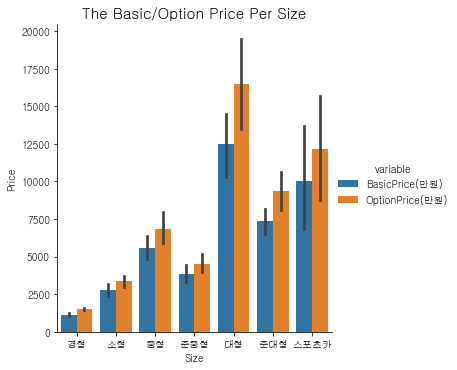

In [138]:
fig = plt.figure(figsize=(20,30), dpi=80)
sns.catplot(x="Size", y="Price", hue="variable", kind="bar", data=temp)
plt.title('The Basic/Option Price Per Size', fontsize=15)

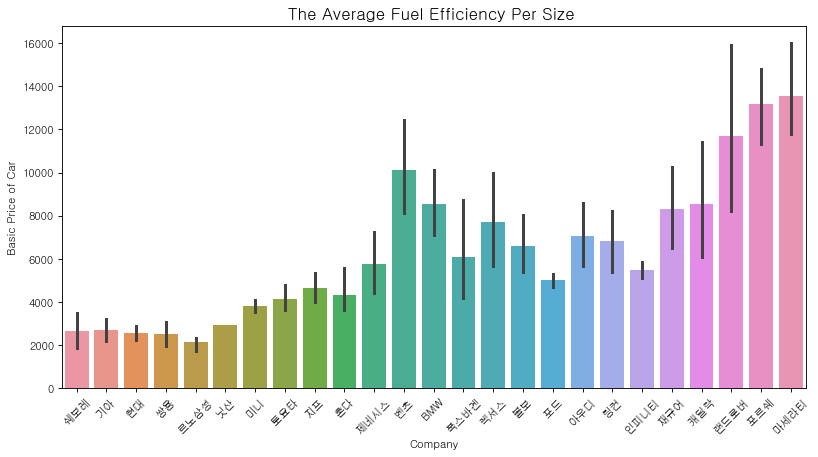

In [74]:
fig = plt.figure(figsize=(12,6), dpi=80)

ax = sns.barplot(
    
    
                x=carIDDF['Company'],
                y=carIDDF['BasicPrice(만원)'])


    
plt.xlabel('Company')
plt.ylabel('Basic Price of Car')
plt.xticks(rotation=45)
plt.title('The Average Fuel Efficiency Per Size ', fontsize=15)
plt.show()

In [28]:
#국산차 데이터프레임 생성
domestic_carIDDF=carIDDF[carIDDF["Car"]=="국산"]

In [29]:
#수입차 데이터프레임 생성
import_carIDDF=carIDDF[carIDDF["Car"]=="수입"]

<Figure size 6000x3000 with 0 Axes>

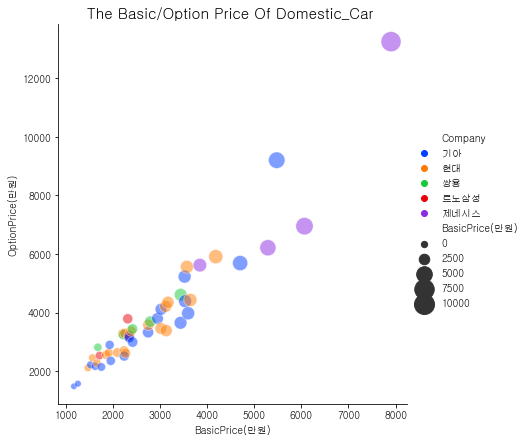

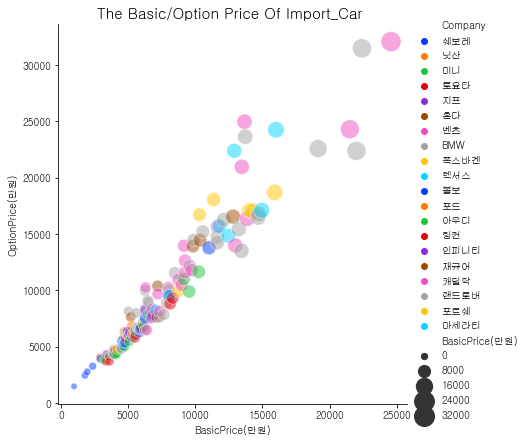

In [109]:
#국산차/수입차 BasicPrice와 OptionPrice 관계


fig = plt.figure(figsize=(20,10), dpi=300)
sns.relplot(x="BasicPrice(만원)", y="OptionPrice(만원)", hue="Company", size="BasicPrice(만원)",sizes=(40, 400), alpha=.5, palette="bright", height=6, data=domestic_carIDDF) 
plt.title('The Basic/Option Price Of Domestic_Car ', fontsize=15)

sns.relplot(x="BasicPrice(만원)", y="OptionPrice(만원)", hue="Company", size="BasicPrice(만원)", sizes=(40, 400), alpha=.5, palette="bright",height=6, data=import_carIDDF) 
plt.title('The Basic/Option Price Of Import_Car ', fontsize=15)

plt.show()


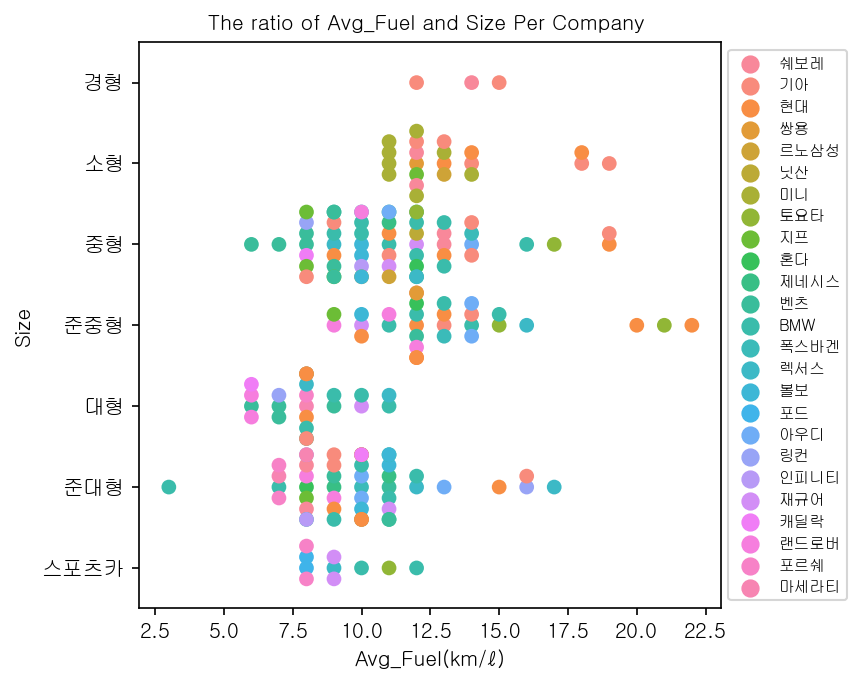

In [130]:
#국산차/수입차 회사별 사이즈에 따른 연비
fig = plt.figure(figsize=(5,5), dpi=150)

sns.swarmplot(x="Avg_Fuel(km/ℓ)", y="Size", hue="Company", sizes=(50,50), data=carIDDF)
plt.title('The ratio of Avg_Fuel and Size Per Company ', fontsize=10)
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), fontsize=7.5)
plt.show()

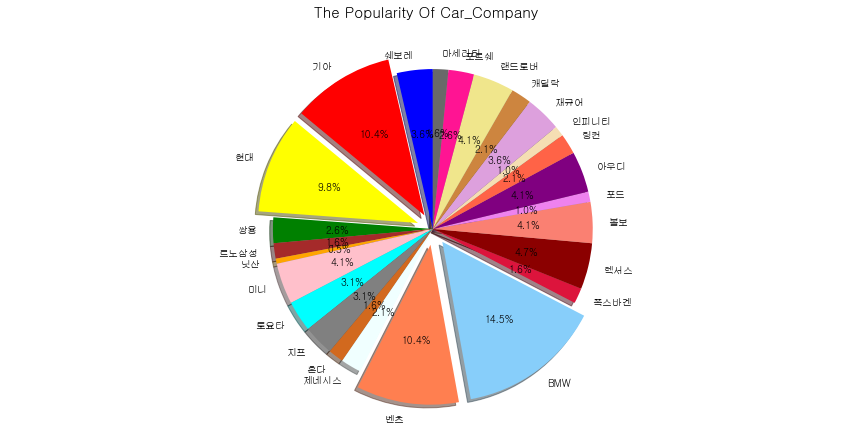

In [67]:
import matplotlib.pyplot as plt

labels = '쉐보레', '기아', '현대', '쌍용', '르노삼성', '닛산', '미니', '토요타', '지프', '혼다','제네시스', '벤츠', 'BMW', '폭스바겐', '렉서스', '볼보', '포드', '아우디', '링컨','인피니티', '재규어', '캐딜락', '랜드로버', '포르쉐', '마세라티'
colors=['blue','red','yellow','green','brown', 'orange', 'pink', 'cyan', 'gray', 'chocolate', 'azure', 'coral','lightskyblue', 'crimson', 'darkred', 'salmon', 'violet','purple','tomato', 'wheat', 'plum','peru', 'khaki','deeppink','dimgray']
sizes = []
explode=[0, 0.1, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0.1, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

#회사별 인기차종 수
for i in range(0, len(carIDDF['Company'].unique())) :
    count=0
    for j in range(0, len(carIDDF)) :
        if carIDDF['Company'].unique()[i]==carIDDF['Company'][j] :
            count+=1    
    sizes.append((count/len(carIDDF))*100)

plt.figure(figsize=(15,7))
plt.pie(sizes, labels=labels, explode=explode, autopct='%1.1f%%', colors=colors, shadow=True, startangle=90)
plt.title('The Popularity Of Car_Company',fontsize=15, position=(0.5, 1.0+0.05))
plt.axis('equal') 
plt.show()

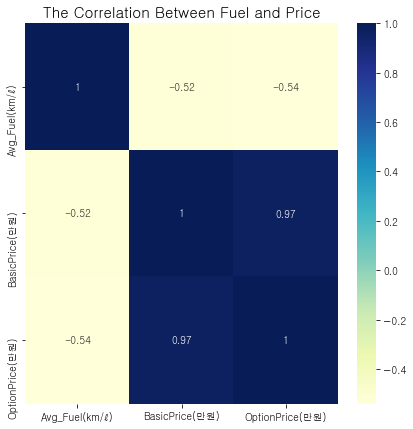

In [137]:
plt.figure(figsize=(7,7))
sns.heatmap(carIDDF.corr(),cmap='YlGnBu', annot=True)
plt.title('The Correlation Between Fuel and Price', fontsize=15)
plt.show()